In [1]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain.agents import tool, create_react_agent
import datetime
from langchain_community.tools import TavilySearchResults
from langchain import hub
import operator
from typing import Annotated, TypedDict, Union, List,Tuple
from langchain_core.agents import AgentAction, AgentFinish
from langgraph.graph import END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [2]:
load_dotenv()

True

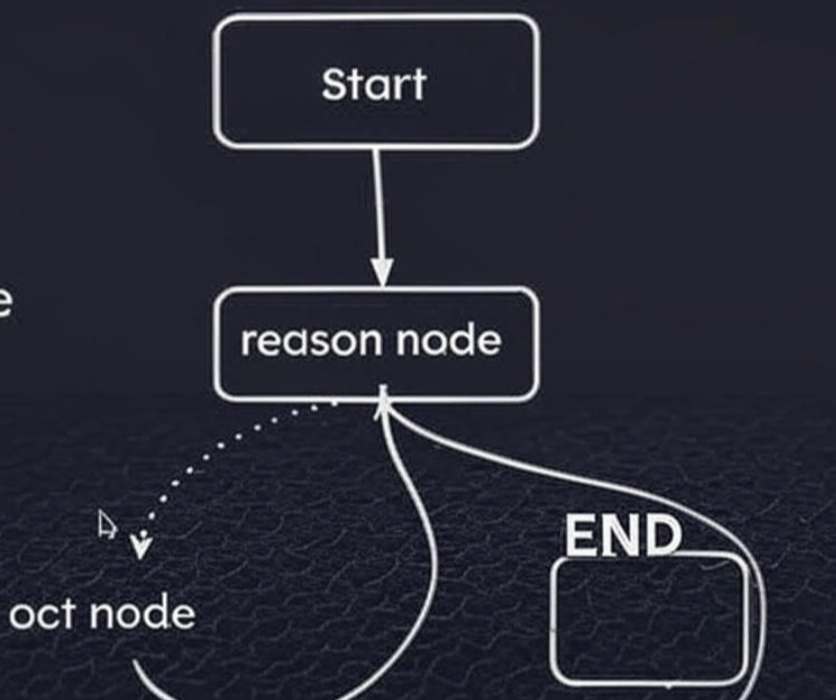

In [3]:
llmGemini=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", temperature=0.5)
llmOpenAI=ChatOpenAI(model="gpt-3.5-turbo",temperature=0.5)

In [4]:
searchTool=TavilySearchResults(search_depth="basic")

In [5]:
@tool
def getSystemTime(format:str="%Y-%m-%d %H:%M:%S"):
    """
        Returns the current date and time in the specified format
    """
    currentTime=datetime.datetime.now()
    formatted_time=currentTime.strftime(format)
    return formatted_time

In [6]:
tools=[searchTool,getSystemTime]

In [7]:
react_prompt=hub.pull(owner_repo_commit="hwchase17/react")
print(react_prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [8]:
react_agent_runnable=create_react_agent(llm=llmGemini,tools=tools,prompt=react_prompt)

In [9]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[ list[ Tuple[ AgentAction, str ] ]  , operator.concat  ]

In [18]:
def reason_node(state:AgentState):
    """
        Input to the agent_outcome attribute from the AgentState Class
    """
    agent_outcome=react_agent_runnable.invoke(input=state)
    print(f"agent_outcome: {agent_outcome}")    
    print(f"agent_outcome_type: {type(agent_outcome)}\n")

    return {"agent_outcome":agent_outcome}

In [10]:
def act_node(state:AgentState):
    """
        Input to the intermediate_steps attribute from the AgentState Class
        Will Execute the Tool
    """
    agent_action=state["agent_outcome"]

    # Extract tool name and input from Agent Action 
    tool_name=agent_action.tool
    tool_input=agent_action.tool_input

    # Find the matching tool function
    tool_function=None
    for tool in tools:
        if tool.name==tool_name:
            tool_function=tool
            break

    # Execute the tool with the input
    if tool_function:
        if isinstance(tool_input,dict):
            output=tool_function.invoke(**tool_input)
        else:
            output=tool_function.invoke(input=tool_input)
    else:
        output=f"Tool: `{tool_name}` not found"
            
    return { "intermediate_steps":[ ( agent_action,str(output) ) ] }  # because the operator.add was defined

In [15]:
REASON_NODE="reason_node"
ACT_NODE="act_node"

In [16]:
def should_continue(state: AgentState) -> str:
    if isinstance(state['agent_outcome'],AgentFinish):
        return "end"
    else:
        return "act_node"

In [17]:
flow=StateGraph(state_schema=AgentState)

In [19]:
flow.add_node(node=REASON_NODE,action=reason_node)

In [20]:
flow.set_entry_point(key=REASON_NODE)

In [21]:
flow.add_node(node=ACT_NODE,action=act_node)

In [22]:
flow.add_conditional_edges(
    source=REASON_NODE,
    path=should_continue,\
        path_map={
            "end":END,
            "act_node":ACT_NODE
            })

In [23]:
flow.add_edge(start_key=ACT_NODE,end_key=REASON_NODE)

In [24]:
app=flow.compile()

In [25]:
app.get_graph().print_ascii()

           +-----------+            
           | __start__ |            
           +-----------+            
                 *                  
                 *                  
                 *                  
          +-------------+           
          | reason_node |           
          +-------------+           
           **         ...           
         **              .          
        *                 ..        
+----------+           +---------+  
| act_node |           | __end__ |  
+----------+           +---------+  


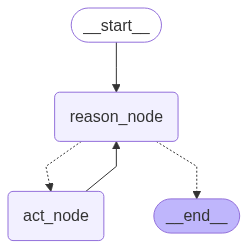

In [26]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png()))

In [27]:
result=app.invoke(input={
    "input":"How many days ago was the Pahalgam Attack",
    "agent_outcome":None, 
    "intermediate_steps":[]
})

agent_outcome: tool='tavily_search_results_json' tool_input='Pahalgam Attack date' log='I need to find out when the Pahalgam Attack happened and then calculate how many days ago that was.\nAction: tavily_search_results_json\nAction Input: "Pahalgam Attack date"'
agent_outcome_type: <class 'langchain_core.agents.AgentAction'>

agent_outcome: tool='getSystemTime' tool_input='%Y-%m-%d' log='The Pahalgam attack happened on April 22, 2025. Now I need to calculate how many days ago that was.\nAction: getSystemTime\nAction Input: %Y-%m-%d'
agent_outcome_type: <class 'langchain_core.agents.AgentAction'>

agent_outcome: tool='getSystemTime' tool_input='%Y-%m-%d' log='The current date is 2025-07-25 and the Pahalgam attack happened on 2025-04-22. To find the number of days ago, I need to subtract the two dates.\nAction: getSystemTime\nAction Input: %Y-%m-%d'
agent_outcome_type: <class 'langchain_core.agents.AgentAction'>

agent_outcome: return_values={'output': 'The Pahalgam Attack was 94 days ag

In [28]:
result

{'input': 'How many days ago was the Pahalgam Attack',
 'agent_outcome': AgentFinish(return_values={'output': 'The Pahalgam Attack was 94 days ago.'}, log='The current date is 2025-07-25 and the Pahalgam attack happened on 2025-04-22. I need to calculate the number of days between these two dates. April has 30 days, May has 31 days, June has 30 days, and July has 31 days.\n\nFrom April 22 to April 30 is 8 days.\nMay has 31 days.\nJune has 30 days.\nFrom July 1 to July 25 is 25 days.\n\n8 + 31 + 30 + 25 = 94 days.\n\nThought: I now know the final answer\nFinal Answer: The Pahalgam Attack was 94 days ago.'),
 'intermediate_steps': [(AgentAction(tool='tavily_search_results_json', tool_input='Pahalgam Attack date', log='I need to find out when the Pahalgam Attack happened and then calculate how many days ago that was.\nAction: tavily_search_results_json\nAction Input: "Pahalgam Attack date"'),
   '[{\'title\': \'2025 Pahalgam attack - Wikipedia\', \'url\': \'https://en.wikipedia.org/wiki/2

In [29]:
result.keys()

dict_keys(['input', 'agent_outcome', 'intermediate_steps'])

In [30]:
result['agent_outcome']

AgentFinish(return_values={'output': 'The Pahalgam Attack was 94 days ago.'}, log='The current date is 2025-07-25 and the Pahalgam attack happened on 2025-04-22. I need to calculate the number of days between these two dates. April has 30 days, May has 31 days, June has 30 days, and July has 31 days.\n\nFrom April 22 to April 30 is 8 days.\nMay has 31 days.\nJune has 30 days.\nFrom July 1 to July 25 is 25 days.\n\n8 + 31 + 30 + 25 = 94 days.\n\nThought: I now know the final answer\nFinal Answer: The Pahalgam Attack was 94 days ago.')

In [31]:
result['agent_outcome'].return_values['output']

'The Pahalgam Attack was 94 days ago.'

In [32]:

result['intermediate_steps']

[(AgentAction(tool='tavily_search_results_json', tool_input='Pahalgam Attack date', log='I need to find out when the Pahalgam Attack happened and then calculate how many days ago that was.\nAction: tavily_search_results_json\nAction Input: "Pahalgam Attack date"'),
  '[{\'title\': \'2025 Pahalgam attack - Wikipedia\', \'url\': \'https://en.wikipedia.org/wiki/2025_Pahalgam_attack\', \'content\': \'The **2025 Pahalgam attack** was a terrorist attack on tourists by five armed terrorists near Pahalgam in Indian-administered Jammu and Kashmir "Jammu and Kashmir (union territory)") in which 26 civilians were killed on 22 April 2025.\', \'score\': 0.9336793}, {\'title\': \'Pahalgam terror attack 2025 - The Hindu\', \'url\': \'https://www.thehindu.com/topic/pahalgam-terror-attack-2025/\', \'content\': \'Terrorists attacked a group of tourists in the Baisaran meadows of Pahalgam, in Jammu and Kashmir, on April 22, 2025, leaving dozens dead and several more\', \'score\': 0.8861155}, {\'title\': 

In [33]:
len(result['intermediate_steps'])

3

In [35]:
result['intermediate_steps'][0]

(AgentAction(tool='tavily_search_results_json', tool_input='Pahalgam Attack date', log='I need to find out when the Pahalgam Attack happened and then calculate how many days ago that was.\nAction: tavily_search_results_json\nAction Input: "Pahalgam Attack date"'),
 '[{\'title\': \'2025 Pahalgam attack - Wikipedia\', \'url\': \'https://en.wikipedia.org/wiki/2025_Pahalgam_attack\', \'content\': \'The **2025 Pahalgam attack** was a terrorist attack on tourists by five armed terrorists near Pahalgam in Indian-administered Jammu and Kashmir "Jammu and Kashmir (union territory)") in which 26 civilians were killed on 22 April 2025.\', \'score\': 0.9336793}, {\'title\': \'Pahalgam terror attack 2025 - The Hindu\', \'url\': \'https://www.thehindu.com/topic/pahalgam-terror-attack-2025/\', \'content\': \'Terrorists attacked a group of tourists in the Baisaran meadows of Pahalgam, in Jammu and Kashmir, on April 22, 2025, leaving dozens dead and several more\', \'score\': 0.8861155}, {\'title\': \'

In [36]:
result['intermediate_steps'][0][0]  # AgentAction

AgentAction(tool='tavily_search_results_json', tool_input='Pahalgam Attack date', log='I need to find out when the Pahalgam Attack happened and then calculate how many days ago that was.\nAction: tavily_search_results_json\nAction Input: "Pahalgam Attack date"')

In [37]:
result['intermediate_steps'][0][1]  # str

'[{\'title\': \'2025 Pahalgam attack - Wikipedia\', \'url\': \'https://en.wikipedia.org/wiki/2025_Pahalgam_attack\', \'content\': \'The **2025 Pahalgam attack** was a terrorist attack on tourists by five armed terrorists near Pahalgam in Indian-administered Jammu and Kashmir "Jammu and Kashmir (union territory)") in which 26 civilians were killed on 22 April 2025.\', \'score\': 0.9336793}, {\'title\': \'Pahalgam terror attack 2025 - The Hindu\', \'url\': \'https://www.thehindu.com/topic/pahalgam-terror-attack-2025/\', \'content\': \'Terrorists attacked a group of tourists in the Baisaran meadows of Pahalgam, in Jammu and Kashmir, on April 22, 2025, leaving dozens dead and several more\', \'score\': 0.8861155}, {\'title\': \'Operation Sindoor: a turning point for India in addressing terrorism ...\', \'url\': \'https://icct.nl/publication/operation-sindoor-turning-point-india-addressing-terrorism-kashmir\', \'content\': \'At the end of British rule, the Hindu ruler of Kashmir - Maharaja 

In [38]:
result['intermediate_steps'][1]

(AgentAction(tool='getSystemTime', tool_input='%Y-%m-%d', log='The Pahalgam attack happened on April 22, 2025. Now I need to calculate how many days ago that was.\nAction: getSystemTime\nAction Input: %Y-%m-%d'),
 '2025-07-25')

In [39]:
result['intermediate_steps'][1][0]

AgentAction(tool='getSystemTime', tool_input='%Y-%m-%d', log='The Pahalgam attack happened on April 22, 2025. Now I need to calculate how many days ago that was.\nAction: getSystemTime\nAction Input: %Y-%m-%d')

In [40]:
result['intermediate_steps'][1][1]

'2025-07-25'